<a href="https://colab.research.google.com/github/giordanovitale/Prado-Museum-CNN/blob/main/Prado_Museum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Source: https://www.kaggle.com/datasets/maparla/prado-museum-pictures

# 0 - Load the necessary libraries

In [1]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 13.7 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import visualkeras as vk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tqdm
import os
import requests
import shutil

from collections import defaultdict
from multiprocessing import cpu_count
from multiprocessing.pool import ThreadPool
from math import exp
from google.colab import userdata

import keras.backend as K
from keras.layers import Layer
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, \
    AveragePooling2D, BatchNormalization, ReLU, \
    Input, Add, Activation, Lambda, RandomFlip, \
    Rescaling, RandomContrast, RandomZoom, RandomRotation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import CSVLogger

# Get rid of the extra stuff that gets downloaded automatically
!rm -rf sample_data

In [3]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [4]:
INPUT_SHAPE = (224,224,3)

# 1 - Helper Functions

## 1.1 - Custom functions for data loading and data counting

In [5]:
def download_images_by_technique(esp_techniques, eng_techniques):

  df_filtered = df[df['technical_sheet_tecnica'] == str(esp_techniques)]
  image_names = df_filtered['work_id'].tolist()

  source_dir = '/content/images/images'
  target_dir = f'data/{eng_techniques}'

  for image_name in image_names:
    source_path = os.path.join(source_dir, image_name)
    target_path = os.path.join(target_dir, image_name)

    if os.path.exists(source_path):
      shutil.copy(source_path, target_path)
  else:
    print(f'Warning: {source_path} does not exist.')

In [34]:
# Function to count the number of samples per class
def count_classes(dataset):
    """
    Count the number of samples per each class.
    input: the dataset
    return: dictionary whose keys are the classes, the values are the counts.
    """
    class_counts = {}
    for images, labels in dataset:
        for label in labels.numpy():
            if label in class_counts:
                class_counts[label] += 1
            else:
                class_counts[label] = 1

    for i, count in class_counts.items():
      print(f"{eng_techniques[i]}: {count}")

## 1.2 - Custom function for visualizing the model performance

In [7]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params)

In [8]:
def plot_history(history, figsize=(12,6), y_lim_left=(0,1), y_lim_right=(0,1.02)):
    """
    Plots the loss and accuracy curves.
    :param df: the data frame containing the histories we want to plot
    :param y_lim: Tuple. If not differently specified, it's (0,1). Only applies to the accuracy plot.
    :return: None
    """
    fig, ax = plt.subplots(figsize=figsize, nrows=1, ncols=2)


    # Plot Loss
    sns.lineplot(data=history,
                 x="epoch",
                 y="val_loss",
                 ax=ax[0],
                 label="Validation Loss",
                 linewidth=2,
                 color="#F58939",
                 errorbar=None)

    sns.lineplot(data=history,
                 x="epoch",
                 y="loss",
                 ax=ax[0],
                 label="Training Loss",
                 linewidth=2,
                 color="#40CA37",
                 errorbar=None)

    # Plot Accuracy
    sns.lineplot(data=history,
                 x="epoch",
                 y="val_accuracy",
                 ax=ax[1],
                 label="Validation Accuracy",
                 linewidth=2,
                 color="#F58939",
                 errorbar=None)

    sns.lineplot(data=history,
                 x="epoch",
                 y="accuracy",
                 ax=ax[1],
                 label="Training Accuracy",
                 linewidth=2,
                 color="#40CA37",
                 errorbar=None)

    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Categorical Crossentropy")
    ax[0].set_title("Training Loss vs Validation Loss")
    ax[0].set_ylim(y_lim_left)
    ax[0].legend()

    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy (%)")
    ax[1].set_title("Training Accuracy vs Validation Accuracy")
    ax[1].set_ylim(y_lim_right)
    ax[1].legend(loc="lower right")

    plt.show()

## 1.3 - Learning rate scheduler

Source: https://keras.io/api/callbacks/learning_rate_scheduler/

In [9]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.05)

# 2 - Load the data

### 2.1 - Download the dataset using the Kaggle API

My Username and Key have been secreted. Replace `userdata.get('KAGGLE_USERNAME')` and `userdata.get('KAGGLE_KEY')`with your username and key, respectively.

In [10]:
os.environ["KAGGLE_USERNAME"] = "userdata.get('KAGGLE_USERNAME')"
os.environ["KAGGLE_KEY"] = "userdata.get('KAGGLE_KEY')"
!kaggle datasets download maparla/prado-museum-pictures

Dataset URL: https://www.kaggle.com/datasets/maparla/prado-museum-pictures
License(s): MIT
100% 24.9G/24.9G [03:16<00:00, 128MB/s]
100% 24.9G/24.9G [03:16<00:00, 136MB/s]


Unzip to obtain all the images.

In [ ]:
!unzip prado-museum-pictures.zip

Create the dataframe from the unzipepd csv file.

In [14]:
df = pd.read_csv(os.path.join("prado.csv"))

Since no target class has been defined from the project assignment, I have to decide it. After a careful inspection of the columns, I found out that the more suitable ones are `author` and `technical_sheet_tecnica`. The latter seems more intriguing as it has more observations, thus being more suitable to big data algorithms.

In [13]:
df.shape

(13487, 30)

### 2.2 - Data exploration to decide the target class (or classes)

In [ ]:
df['author'].value_counts()

author
Anónimo                                                                       2698
Goya y Lucientes, Francisco de                                                1080
Bayeu y Subías, Francisco                                                      446
Haes, Carlos de                                                                326
Pizarro y Librado, Cecilio                                                     290
                                                                              ... 
Malombra, Pietro                                                                 1
Taller de Bellini, Giovanni                                                      1
Mattioli, Ludovico -Dibujante- (Autor de la obra original: Cignani, Carlo)       1
Ricci, Marco                                                                     1
García, Sergio                                                                   1
Name: count, Length: 2560, dtype: int64

In [ ]:
df['technical_sheet_tecnica'].value_counts().sort_values(ascending=False)[:10]

technical_sheet_tecnica
Óleo                    4156
Acuñación               1118
Esculpido                550
Lápiz compuesto          476
Clarión; Lápiz negro     396
Albúmina                 395
Sanguina                 372
Lápiz                    259
Lápiz negro              237
Pluma; Tinta parda       214
Name: count, dtype: int64

Reduce the data set by keeping observations belonging to the 4 classes of interest only.

In [ ]:
# df = df[df['technical_sheet_tecnica'].isin(['Óleo',
#                                             'Acuñación',
#                                             'Esculpido',
#                                             'Lápiz compuesto'])]

In [ ]:
# df.shape

(6300, 30)

### 2.3 - Move the downloaded images to the corresponding folders

Obtain the .JPG name of each image.

In [15]:
df['work_id'] = df['work_image_url'].apply(lambda x: x.split('/')[-1])

Create the folders into which the images will be stored, according to their respective class.

In [16]:
!mkdir data # This will be the parent folder of the following ones

In [17]:
esp_techniques = ['Óleo', 'Acuñación', 'Esculpido', 'Lápiz compuesto']
eng_techniques = ['oil', 'minting', 'sculpture', 'pencil']

Create the sub folders

In [18]:
for technique in eng_techniques:
  !mkdir -p data/$technique

Populate the `data/technique` folders using the function above defined.

In [19]:
for esp_technique, eng_technique in zip(esp_techniques, eng_techniques):
  download_images_by_technique(esp_technique, eng_technique)

### 2.4 - Finally load the data

In [20]:
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory('/content/data',
                                                                label_mode='int',
                                                                color_mode='rgb',
                                                                batch_size=32,
                                                                image_size=(224, 224),
                                                                shuffle=True,
                                                                seed=42,
                                                                validation_split=0.2,
                                                                subset='both',
                                                                labels='inferred',
                                                                class_names=['oil', 'minting', 'sculpture', 'pencil'])

Found 6293 files belonging to 4 classes.
Using 5035 files for training.
Using 1258 files for validation.


### 2.5 - Check how many images in each class, for both training and test

In [37]:
count_classes(train_ds)

minting: 916
oil: 3302
pencil: 375
sculpture: 442


In [38]:
count_classes(test_ds)

oil: 847
sculpture: 108
minting: 202
pencil: 101


# 3 - Class imbalance + misc

Source used to apply data augmentation techniques: https://www.tensorflow.org/tutorials/images/data_augmentation

From this link, the following quote is foundamental:
> Note: Data augmentation is inactive at test time so input images will only be augmented during calls to Model.fit (not Model.evaluate or Model.predict).

***



Source: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights

In [64]:
num_oils = df.loc[df['technical_sheet_tecnica']=='Óleo'].shape[0]
num_mintings = df.loc[df['technical_sheet_tecnica']=='Acuñación'].shape[0]
num_sculptures = df.loc[df['technical_sheet_tecnica']=='Esculpido'].shape[0]
num_pencils = df.loc[df['technical_sheet_tecnica']=='Lápiz compuesto'].shape[0]

num_total = df.shape[0]

In [65]:
class_weights = {
    0: round((1/num_oils)*num_total, 2),
    1: round((1/num_mintings)*num_total, 2),
    2: round((1/num_sculptures)*num_total, 2),
    3: round((1/num_pencils)*num_total, 2)
}

class_weights

{0: 3.25, 1: 12.06, 2: 24.52, 3: 28.33}

In [66]:
num_total

13487

***

Define the number of classes.

In [ ]:
num_classes = 4

Create the folders where the models' results will be stored.

In [ ]:
!mkdir model_logs

# 4 - First Model: ZFNet

In [ ]:
zfnet = Sequential([

    # Preprocessing layers
    tf.keras.layers.Rescaling(1./255,
                              input_shape=INPUT_SHAPE,
                              name='rescaling'),
    tf.keras.layers.RandomFlip(mode='horizontal_and_vertical',
                               input_shape=INPUT_SHAPE,
                               name='Random_Horizontal_And_Vertical_Flip'),
    tf.keras.layers.RandomRotation(factor=0.2,
                                   input_shape=INPUT_SHAPE,
                                   name='Random_Rotation'),
    tf.keras.layers.RandomContrast(factor=0.2,
                                   input_shape=INPUT_SHAPE,
                                   name='Random_Contrast'),
    tf.keras.layers.RandomZoom(height_factor=(-0.2, -0.1),
                               input_shape=INPUT_SHAPE,
                               name='Random_Zoom'),


    # 1st convolutional block
    Conv2D(filters=48,
           kernel_size=(7,7),
           strides=(2,2),
           padding='valid',
           activation=None,
           name='Conv_1'),
    ReLU(name='ReLU_1'),
    MaxPooling2D(pool_size=(3,3),
                 strides=(2,2),
                 padding='valid',
                 name='Max_Pooling_1'),

    # 2nd convolutional block
    Conv2D(filters=128,
           kernel_size=(3,3),
           strides=(2,2),
           padding='valid',
           activation=None,
           name='Conv_2'),
    ReLU(name='ReLU_2'),
    MaxPooling2D(pool_size=(3,3),
                 strides=(2,2),
                 padding='valid',
                 name='Max_Pooling_2'),

    # 3rd convolutional block
    Conv2D(filters=192,
           kernel_size=(3,3),
           strides=(1,1),
           padding='valid',
           activation=None,
           name='Conv_3.1'),
    ReLU(name='ReLU_3.1'),
    Conv2D(filters=192,
           kernel_size=(3,3),
           strides=(1,1),
           padding='valid',
           activation=None,
           name='Conv_3.2'),
    ReLU(name='ReLU_3.2'),
    Conv2D(filters=128,
           kernel_size=(3,3),
           strides=(1,1),
           padding='valid',
           activation=None,
           name='Conv_3.3'),
    ReLU(name='ReLU_3.3'),
    MaxPooling2D(pool_size=(3,3),
                 strides=(2,2),
                 padding='valid',
                 name='Max_Pooling_3'),

    # Flatten Layer
    Flatten(name='Flatten'),

    # 1st Dense Layer
    Dense(units=256,
          activation='relu',
          name='Dense_1'),

    # 2nd Dense Layer
    Dense(units=256,
          activation='relu',
          name='Dense_2'),

    # 3rd Dense Layer
    Dense(units=num_classes,
          activation='softmax',
          name="Output")
],
    name='ZFNet')

In [ ]:
zfnet.build(input_shape=(None, *INPUT_SHAPE))
zfnet.summary()

Model: "ZFNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 Random_Horizontal_And_Vert  (None, 224, 224, 3)       0         
 ical_Flip (RandomFlip)                                          
                                                                 
 Random_Rotation (RandomRot  (None, 224, 224, 3)       0         
 ation)                                                          
                                                                 
 Random_Contrast (RandomCon  (None, 224, 224, 3)       0         
 trast)                                                          
                                                                 
 Random_Zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                             

Model compiling.

In [ ]:
zfnet.compile(loss=SparseCategoricalCrossentropy(),
              optimizer=Adam(),
              metrics=["accuracy"])

Create csv logger to save the results in case it stops.

In [ ]:
zfnet_csv_logger = CSVLogger("/content/model_logs/zfnet.log")

Train the model.

In [ ]:
zfnet_history = zfnet.fit(train_ds,
                          epochs=50,
                          steps_per_epoch=len(train_ds),
                          validation_data=test_ds,
                          validation_steps=len(test_ds),
                          class_weight=class_weights,
                          callbacks=zfnet_csv_logger)

Visualize the architecture.

In [ ]:
color_map = defaultdict(dict)

color_map[AveragePooling2D]["fill"] = "#25bdf0"
color_map[Dense]["fill"] = "#78ba41"

vk.layered_view(zfnet,
                legend=True,
                scale_xy=2,
                scale_z=.01,
                type_ignore=[Rescaling, RandomFlip, RandomRotation, RandomContrast,
                RandomZoom, Lambda],
                color_map=color_map
                )

Visualize its performance.

In [ ]:
zfnet_history = pd.read_csv("/content/model_logs/zfnet.log")
plot_history(zfnet_history, y_lim_right=(0.55,1.005), figsize=(12,5))

# 5 - Second Model: GioNet

In [ ]:
gionet = Sequential([

    # Preprocessing layers
    tf.keras.layers.Rescaling(1./255,
                              input_shape=INPUT_SHAPE,
                              name='Rescaling'),
    tf.keras.layers.RandomFlip(mode='horizontal_and_vertical',
                               input_shape=INPUT_SHAPE,
                               name='Random_Horizontal_And_Vertical_Flip'),
    tf.keras.layers.RandomRotation(factor=0.2,
                                   input_shape=INPUT_SHAPE,
                                   name='Random_Rotation'),
    tf.keras.layers.RandomContrast(factor=0.2,
                                   input_shape=INPUT_SHAPE,
                                   name='Random_Contrast'),
    tf.keras.layers.RandomZoom(height_factor=(-0.2, -0.1),
                               input_shape=INPUT_SHAPE,
                               name='Random_Zoom'),
    tf.keras.layers.Lambda(function=tf.image.per_image_standardization,
                           name="Per_image_standardisation"),


    # 1st convolutional block
    Conv2D(filters=224,
           kernel_size=(3,3),
           strides=(2,2),
           padding='same',
           activation=None,
           name='Conv_1'),
    ReLU(name='ReLU_1'),
    AveragePooling2D(pool_size=(3,3),
                     strides=(2,2),
                     padding='same',
                     name='Avg_Pooling_1'),


    # 2nd convolutional block
    Conv2D(filters=112,
           kernel_size=(3,3),
           strides=(2,2),
           padding='same',
           activation=None,
           name='Conv_2'),
    ReLU(name='ReLU_2'),
    AveragePooling2D(pool_size=(3,3),
                     strides=(2,2),
                     padding='same',
                     name='Avg_Pooling_2'),

    # 3rd convolutional block
    Conv2D(filters=56,
           kernel_size=(5,5),
           strides=(2,2),
           padding='same',
           activation=None,
           name='Conv_3'),
    ReLU(name='ReLU_3'),
    AveragePooling2D(pool_size=(3,3),
                     strides=(2,2),
                     padding='same',
                     name='Avg_Pooling_3'),

    # 4th convolutional block
    Conv2D(filters=28,
           kernel_size=(7,7),
           strides=(1,1),
           padding='same',
           activation=None,
           name='Conv_4.1'),
    ReLU(name='ReLU_4.1'),
    Conv2D(filters=28,
           kernel_size=(5,5),
           strides=(1,1),
           padding='same',
           activation=None,
           name='Conv_4.2'),
    ReLU(name='ReLU_4.2'),
    AveragePooling2D(pool_size=(3,3),
                     strides=(2,2),
                     padding='valid',
                     name='Avg_Pooling_4'),

    # Flatten Layer
    Flatten(name='Flatten'),

    # 1st Dense Layer
    Dense(units=64,
          activation='relu',
          name='Dense_1'),

    # 2nd Dense Layer
    Dense(units=num_classes,
          activation='softmax',
          name="Output")
],
    name='GioNet')

In [ ]:
gionet.build(input_shape=(None, *INPUT_SHAPE))
gionet.summary()

Model: "GioNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 Random_Horizontal_And_Vert  (None, 224, 224, 3)       0         
 ical_Flip (RandomFlip)                                          
                                                                 
 Random_Rotation (RandomRot  (None, 224, 224, 3)       0         
 ation)                                                          
                                                                 
 Random_Contrast (RandomCon  (None, 224, 224, 3)       0         
 trast)                                                          
                                                                 
 Random_Zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                            

Compile the model

In [ ]:
gionet.compile(loss=SparseCategoricalCrossentropy(),
               optimizer=Adam(),
               metrics=['accuracy'])

CSV logger in case it stops.

In [ ]:
gionet_csv_logger = CSVLogger("/content/model_logs/gionet.log")

Train the model.

In [ ]:
gionet_history = gionet.fit(train_ds,
                            epochs=50,
                            steps_per_epoch=len(train_ds),
                            validation_data=test_ds,
                            validation_steps=len(test_ds),
                            class_weight=class_weights,
                            callbacks=gionet_csv_logger)

Epoch 1/50
149/149 [==============================] - 37s 203ms/step - loss: 0.1474 - accuracy: 0.7422 - val_loss: 0.6583 - val_accuracy: 0.7902
Epoch 2/50
149/149 [==============================] - 33s 211ms/step - loss: 0.0645 - accuracy: 0.8359 - val_loss: 0.8852 - val_accuracy: 0.8138
Epoch 3/50
149/149 [==============================] - 33s 211ms/step - loss: 0.0460 - accuracy: 0.8755 - val_loss: 0.3635 - val_accuracy: 0.9191
Epoch 4/50
149/149 [==============================] - 33s 211ms/step - loss: 0.0376 - accuracy: 0.9120 - val_loss: 0.2250 - val_accuracy: 0.9444
Epoch 5/50
149/149 [==============================] - 33s 210ms/step - loss: 0.0381 - accuracy: 0.9160 - val_loss: 0.3158 - val_accuracy: 0.9115
Epoch 6/50
149/149 [==============================] - 33s 210ms/step - loss: 0.0299 - accuracy: 0.9396 - val_loss: 0.1924 - val_accuracy: 0.9495
Epoch 7/50
149/149 [==============================] - 33s 210ms/step - loss: 0.0268 - accuracy: 0.9429 - val_loss: 0.2536 - val_ac

Visualize the architecture.

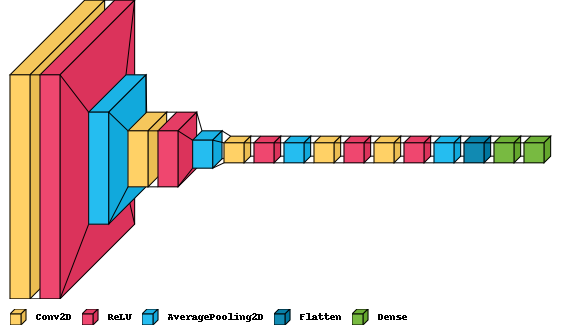

In [ ]:
color_map = defaultdict(dict)


color_map[AveragePooling2D]["fill"] = "#25bdf0"
color_map[Dense]["fill"] = "#78ba41"

vk.layered_view(gionet,
                legend=True,
                scale_xy=2,
                scale_z=.01,
                type_ignore=[Rescaling, RandomFlip, RandomRotation, RandomContrast,
                RandomZoom, Lambda],
                color_map=color_map
                )

Visualize its performance.

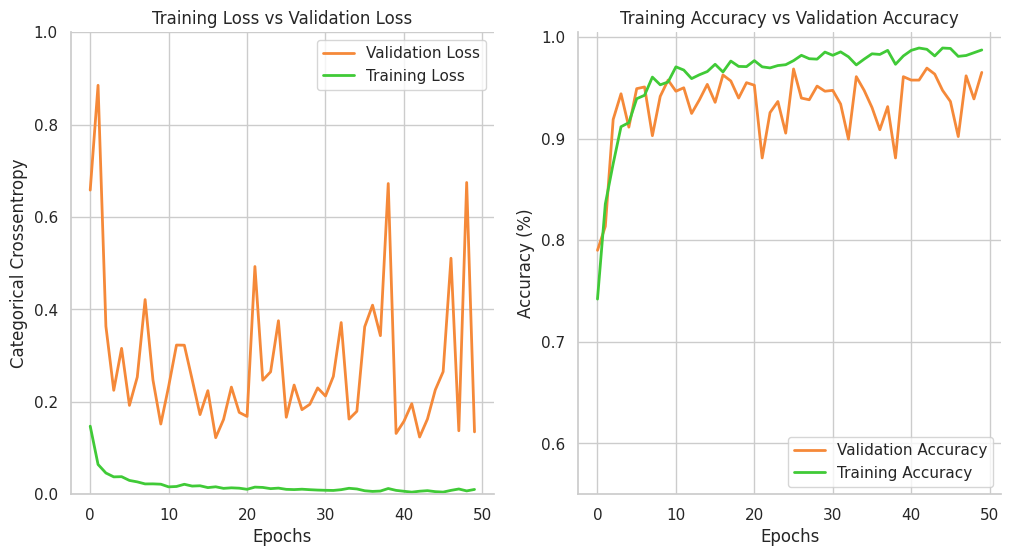

In [ ]:
gionet_history = pd.read_csv("/content/model_logs/gionet.log")
plot_history(gionet_history, y_lim_right=(0.55,1.005))

# 6 - Third Model: GioNetV2

Novelty in initializer: https://keras.io/api/layers/initializers/

In [ ]:
gionetv2 = Sequential([

    # A bit difference in the pre-processing steps
    tf.keras.layers.Rescaling(1./255,
                              input_shape=INPUT_SHAPE,
                              name='rescaling'),
    tf.keras.layers.RandomFlip(mode='horizontal_and_vertical',
                               input_shape=INPUT_SHAPE,
                               name='Random_Horizontal_And_Vertical_Flip'),
    tf.keras.layers.RandomContrast(factor=0.2,
                                   input_shape=INPUT_SHAPE,
                                   name='Random_Contrast'),
    tf.keras.layers.Lambda(function=tf.image.per_image_standardization,
                           name='Per_image_standardisation'),

    # 1st convolutional block
    Conv2D(filters=32,
           kernel_size=(7,7),
           strides=(2,2),
           padding='same',
           activation=None,
           kernel_initializer='he_normal',
           name='Conv_1'),
    BatchNormalization(name='BatchNormalization_1'),
    ReLU(name='ReLU_1'),

    #2nd Convolutional block
    Conv2D(filters=64,
           kernel_size=(5,5),
           strides=(2,2),
           padding='same',
           activation=None,
           kernel_initializer='he_normal',
           name='Conv_2.1'),
    BatchNormalization(name='BatchNormalization_2.1'),
    ReLU(name='ReLU_2.1'),

    Conv2D(filters=64,
           kernel_size=(5,5),
           strides=(2,2),
           padding='same',
           activation=None,
           kernel_initializer='he_normal',
           name='Conv_2.2'),
    BatchNormalization(name='BatchNormalization_2.2'),
    ReLU(name='ReLU_2.2'),

    #3rd Convolutional block
    Conv2D(filters=128,
           kernel_size=(3,3),
           strides=(2,2),
           padding='same',
           activation=None,
           kernel_initializer='he_normal',
           name='Conv_3.1'),
    BatchNormalization(name='BatchNormalization_3.1'),
    ReLU(name='ReLU_3.1'),

    Conv2D(filters=128,
           kernel_size=(3,3),
           strides=(2,2),
           padding='same',
           activation=None,
           kernel_initializer='he_normal',
           name='Conv_3.2'),
    BatchNormalization(name='BatchNormalization_3.2'),
    ReLU(name='ReLU_3.2'),

    # Flatten layer
    Flatten(name='Flatten'),

    # Final Dense layer
    Dense(units=num_classes,
          activation='softmax',
          name='Output')

], name='GioNetV2')

In [ ]:
gionetv2.build(input_shape=(None, *INPUT_SHAPE))
gionetv2.summary()

Model: "GioNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 Random_Horizontal_And_Vert  (None, 224, 224, 3)       0         
 ical_Flip (RandomFlip)                                          
                                                                 
 Random_Contrast (RandomCon  (None, 224, 224, 3)       0         
 trast)                                                          
                                                                 
 Per_image_standardisation   (None, 224, 224, 3)       0         
 (Lambda)                                                        
                                                                 
 Conv_1 (Conv2D)             (None, 112, 112, 32)      4736      
                                                          

Compile the model.

In [ ]:
gionetv2.compile(loss=SparseCategoricalCrossentropy(),
                 optimizer=Adam(),
                 metrics=['accuracy'])

CSV logger in case it stops.

In [ ]:
gionetv2_csv_logger = CSVLogger("/content/model_logs/gionetv2.log")
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

Train the model.

In [ ]:
gionetv2_history = gionetv2.fit(train_ds,
                                epochs=50,
                                steps_per_epoch=len(train_ds),
                                validation_data=test_ds,
                                validation_steps=len(test_ds),
                                class_weight=class_weights,
                                callbacks=[gionetv2_csv_logger, lr_scheduler])

Epoch 1/50
149/149 [==============================] - 34s 216ms/step - loss: 3.1221e-04 - accuracy: 0.9996 - val_loss: 0.0420 - val_accuracy: 0.9924 - lr: 4.2742e-04
Epoch 2/50
149/149 [==============================] - 35s 222ms/step - loss: 1.6601e-04 - accuracy: 0.9996 - val_loss: 0.0418 - val_accuracy: 0.9924 - lr: 4.2742e-04
Epoch 3/50
149/149 [==============================] - 33s 213ms/step - loss: 1.1794e-04 - accuracy: 0.9996 - val_loss: 0.0430 - val_accuracy: 0.9933 - lr: 4.2742e-04
Epoch 4/50
149/149 [==============================] - 33s 215ms/step - loss: 9.2841e-05 - accuracy: 0.9998 - val_loss: 0.0447 - val_accuracy: 0.9933 - lr: 4.2742e-04
Epoch 5/50
149/149 [==============================] - 33s 213ms/step - loss: 1.8190e-04 - accuracy: 0.9996 - val_loss: 0.0434 - val_accuracy: 0.9916 - lr: 4.2742e-04
Epoch 6/50
149/149 [==============================] - 34s 216ms/step - loss: 2.7150e-04 - accuracy: 0.9998 - val_loss: 0.0442 - val_accuracy: 0.9941 - lr: 4.2742e-04
Epoc

Visualize the architecture.

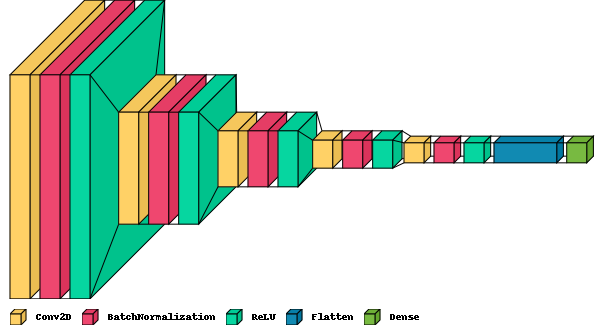

In [ ]:
color_map = defaultdict(dict)

color_map[AveragePooling2D]["fill"] = "#25bdf0"
color_map[Dense]["fill"] = "#78ba41"

vk.layered_view(gionetv2,
                legend=True,
                scale_xy=2,
                scale_z=.01,
                type_ignore=[Rescaling, RandomFlip, RandomRotation, RandomContrast,
                RandomZoom, Lambda],
                color_map=color_map
                )

Visualize its performance.

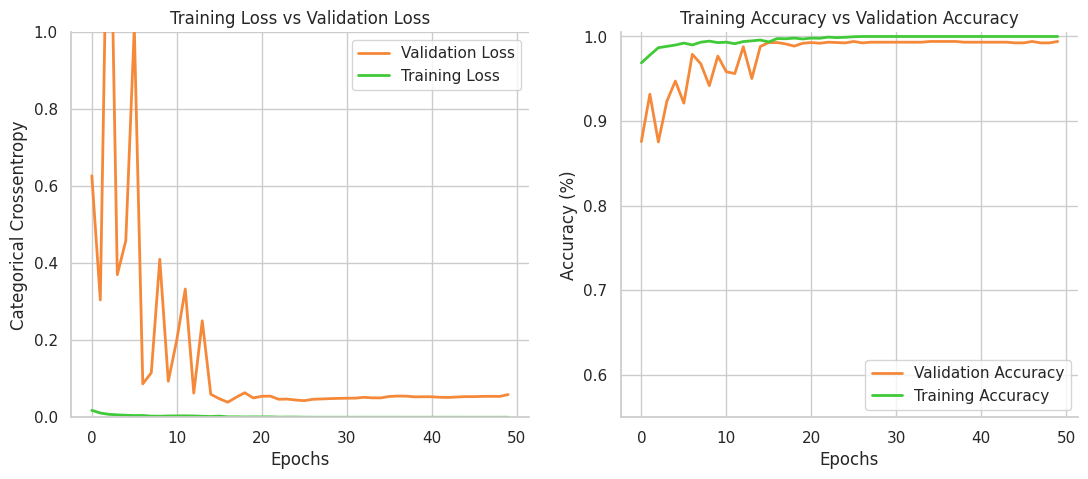

In [ ]:
gionetv2_history = pd.read_csv("/content/model_logs/gionetv2.log")
plot_history(gionetv2_history,
             y_lim_left=(0,1.0),
             y_lim_right=(0.55,1.005),
             figsize=(13,5))

# 7 - Overall Comparison

In [ ]:
gionetv2_history = pd.read_csv("/content/model_logs/gionetv2.log")
gionet_history = pd.read_csv("/content/model_logs/gionet.log")
zfnet_history = pd.read_csv('/content/model_logs/zfnet.log')

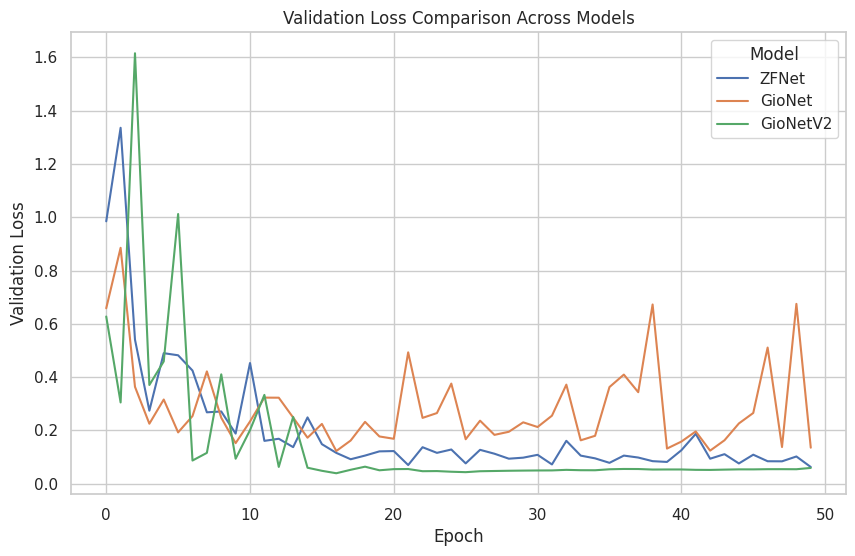

In [ ]:
plt.figure(figsize=(10, 6))

sns.set_style('whitegrid')
sns.lineplot(data=zfnet_history,
             x='epoch',
             y='val_loss',
             label='ZFNet')
sns.lineplot(data=gionet_history,
             x='epoch',
             y='val_loss',
             label='GioNet')
sns.lineplot(data=gionetv2_history,
             x='epoch',
             y='val_loss',
             label='GioNetV2',
             errorbar=None)
plt.title('Validation Loss Comparison Across Models')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(title='Model')

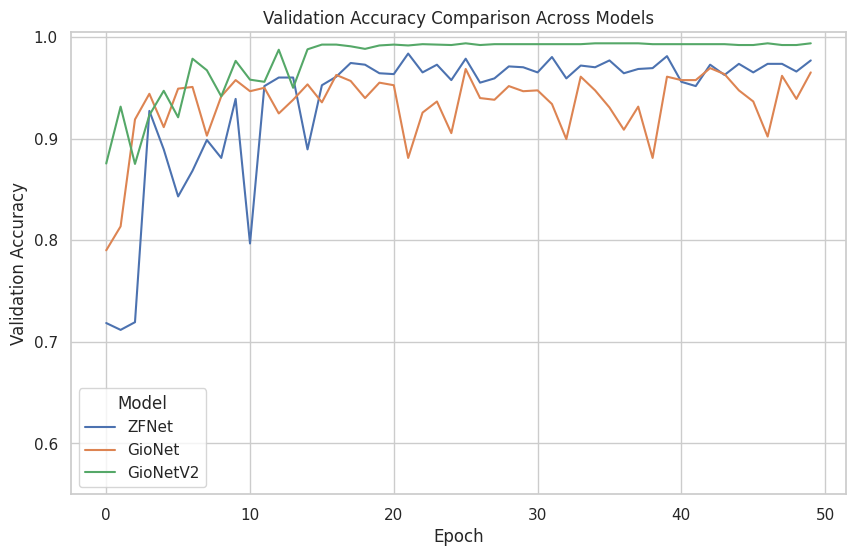

In [ ]:
plt.figure(figsize=(10, 6))

sns.set_style('whitegrid')
sns.lineplot(data=zfnet_history,
             x='epoch',
             y='val_accuracy',
             label='ZFNet')
sns.lineplot(data=gionet_history,
             x='epoch',
             y='val_accuracy',
             label='GioNet')
sns.lineplot(data=gionetv2_history,
             x='epoch',
             y='val_accuracy',
             label='GioNetV2',
             errorbar=None)
plt.ylim(0.55,1.005)
plt.title('Validation Accuracy Comparison Across Models')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(title='Model')

# 8 - Data augmentation plots for the report

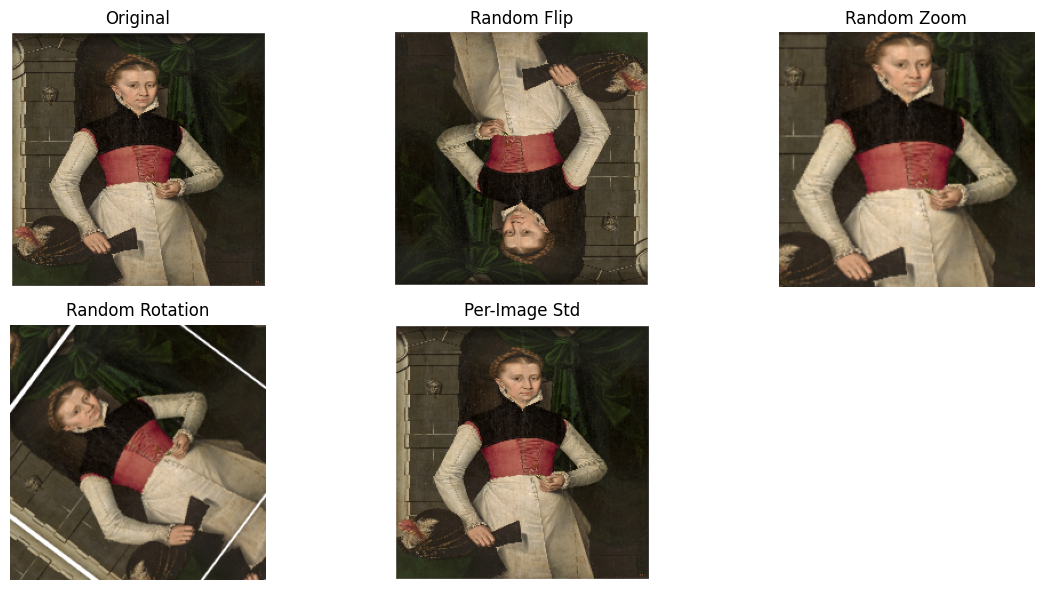

In [43]:
# Select one image as an example
sample_image = tf.keras.preprocessing.image.load_img('/content/data/oil/fff0f33e-1f29-481a-b8a9-4cc608153370.jpg',
                                                     grayscale=False,
                                                     color_mode='rgb')
sample_image = tf.keras.preprocessing.image.img_to_array(sample_image)
sample_image = tf.image.resize(sample_image, [224, 224])

# Apply the augmentation layers deployed in the previous models
random_flip = tf.keras.layers.RandomFlip(mode='horizontal_and_vertical')
random_contrast = tf.keras.layers.RandomContrast(factor=0.8)
random_zoom = tf.keras.layers.RandomZoom(height_factor=0.3)
random_rotation = tf.keras.layers.RandomRotation(factor=0.2)
per_image_stand = tf.keras.layers.Lambda(function=tf.image.per_image_standardization)

# Apply and visualize augmentations
augmented_images = {
    'Original': sample_image,
    'Random Flip': random_flip(sample_image),
    'Random Contrast': random_contrast(sample_image),
    'Random Zoom': random_zoom(sample_image),
    'Random Rotation': random_rotation(sample_image),
    'Per-Image Std': per_image_stand(sample_image)
}

# Plot original and augmented images
plt.figure(figsize=(12, 6))

for i, (title, img) in enumerate(augmented_images.items()):
    plt.subplot(2, 3, i+1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img))
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()